
0: 384x480 2 garbages, 460.3ms
Speed: 13.0ms preprocess, 460.3ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 480)


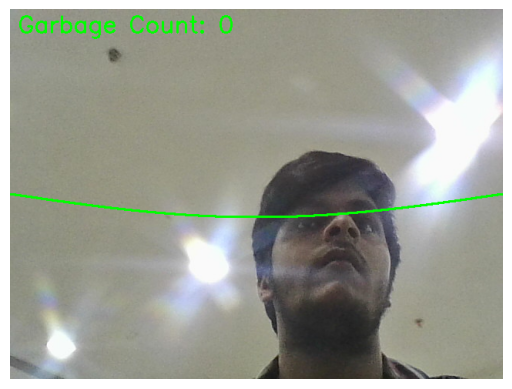


0: 384x480 3 garbages, 391.9ms
Speed: 3.2ms preprocess, 391.9ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 480)


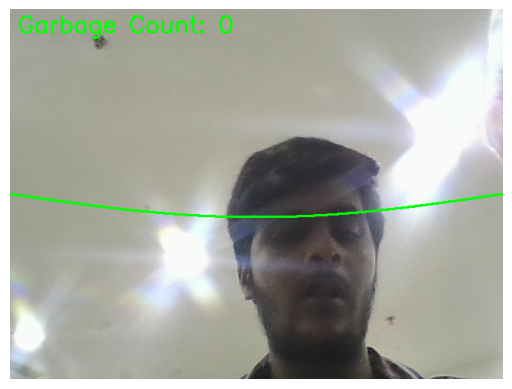


0: 384x480 1 garbage, 379.1ms
Speed: 2.2ms preprocess, 379.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 480)

0: 512x512 2 Wet Wastes, 851.2ms
Speed: 0.0ms preprocess, 851.2ms inference, 9.5ms postprocess per image at shape (1, 3, 512, 512)
Garbage detected: Wet Waste with confidence 0.49


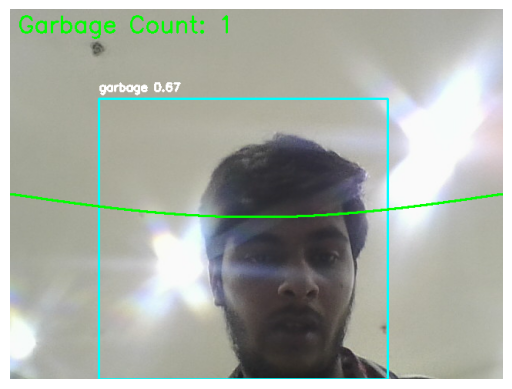


0: 384x480 1 garbage, 320.1ms
Speed: 3.0ms preprocess, 320.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 480)

0: 512x416 1 Wet Waste, 600.7ms
Speed: 0.0ms preprocess, 600.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 416)
Garbage detected: Wet Waste with confidence 0.67


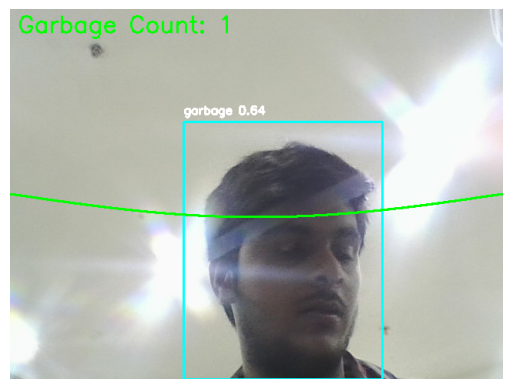


0: 384x480 1 garbage, 423.6ms
Speed: 2.0ms preprocess, 423.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 480)

0: 512x512 2 Dry Wastes, 744.5ms
Speed: 3.3ms preprocess, 744.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
Garbage detected: Dry Waste with confidence 0.77


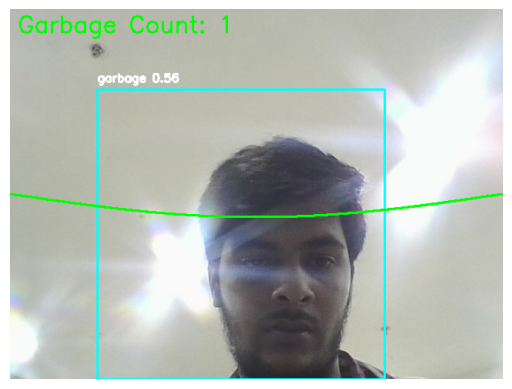


0: 384x480 (no detections), 308.2ms
Speed: 0.0ms preprocess, 308.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 480)


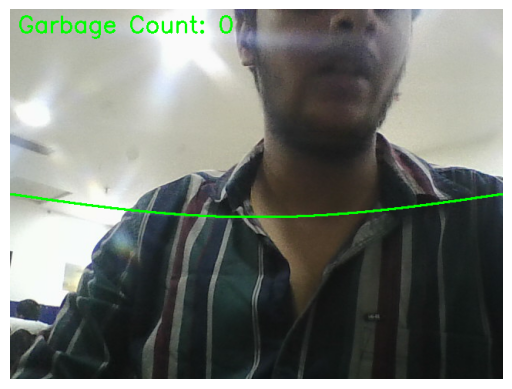


0: 384x480 (no detections), 323.4ms
Speed: 3.5ms preprocess, 323.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 480)


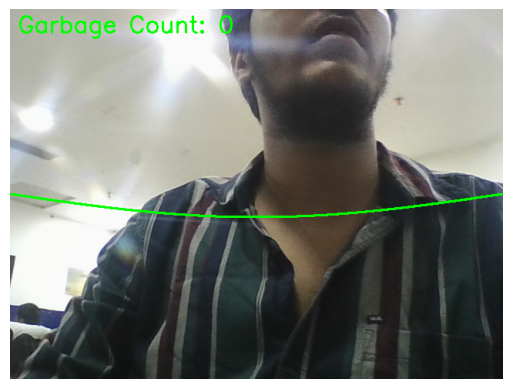


0: 384x480 (no detections), 369.0ms
Speed: 2.6ms preprocess, 369.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 480)


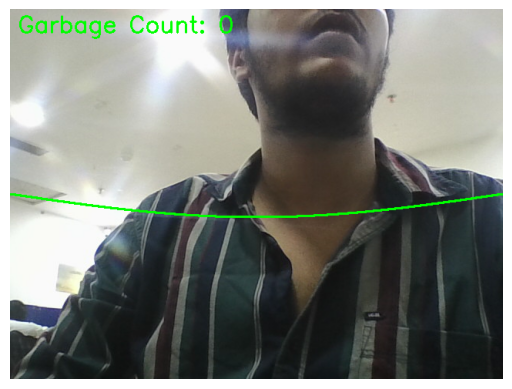

In [2]:
import cv2
import numpy as np
import time
from sklearn.neighbors import KNeighborsRegressor
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your custom YOLO model for garbage detection
garbage_model = YOLO('C:/Users/HP/Downloads/R1-20241015T142216Z-001/R1/runs/detect/train/weights/best.pt')

# Load the dry/wet classification model
dry_wet_model = YOLO('C:/Users/HP/Downloads/Dry-Model-20241010T131307Z-001/Dry-Model/Dataset/runs/detect/train2/weights/best.pt')

# Open video capture (0 for default camera)
cap = cv2.VideoCapture(0)

# Create a more detailed dataset for KNN (bounding box size vs distance)
bbox_size = np.array([[50, 50], [100, 100], [150, 150], [200, 200], [250, 250]])  # Example values
distance = np.array([3, 2, 1.5, 1, 0.5])  # Corresponding distances in meters

# Initialize KNN regressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(bbox_size, distance)  # Train the KNN model

# Set start time
start_time = time.time()

# Define boundary parameters
boundary_distance = 1.0  # 1 meter

# Define the figure and axis for Matplotlib
plt.figure()
plt.ion()  # Enable interactive mode

# Function to draw a curved boundary line centered in the frame
def draw_curved_boundary(frame):
    frame_height, frame_width = frame.shape[:2]
    curve_depth = 30  # Control the maximum depth of the curve above and below the midpoint
    curve_center_y = frame_height // 2  # Midpoint height

    num_points = frame_width
    curve_points = []

    for x in range(num_points):
        t = x / (frame_width - 1)  # Parameter from 0 to 1
        y = curve_center_y + int(curve_depth * np.sin(np.pi * t))
        curve_points.append((x, y))

    for i in range(len(curve_points) - 1):
        cv2.line(frame, curve_points[i], curve_points[i + 1], (0, 255, 0), 2)

    return frame

# Loop to capture frames
while True:
    ret, frame = cap.read()  # Capture frame from camera
    if not ret:  # Check if frame is captured correctly
        print("Failed to capture frame. Exiting...")
        break

    # Perform garbage detection
    garbage_results = garbage_model(frame)

    garbage_count = 0
    closest_outside_distance = float('inf')
    closest_label = ""

    for result in garbage_results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            class_id = box.cls[0]

            if conf < 0.5:  # Adjust this threshold as needed
                continue

            garbage_count += 1

            # Draw bounding box around detected garbage
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
            cv2.putText(frame, f'{garbage_model.names[int(class_id)]} {conf:.2f}', 
                        (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

            cropped_garbage = frame[y1:y2, x1:x2]  # Crop the detected garbage for dry/wet classification

            dry_wet_results = dry_wet_model(cropped_garbage)
            dry_wet_label = 'Common'
            dry_wet_confidence = 0.0

            for dw_result in dry_wet_results:
                if len(dw_result.boxes) > 0:
                    dw_class_id = dw_result.boxes[0].cls[0]
                    dry_wet_label = dry_wet_model.names[int(dw_class_id)]
                    dry_wet_confidence = dw_result.boxes[0].conf[0]

            print(f"Garbage detected: {dry_wet_label} with confidence {dry_wet_confidence:.2f}")
            cv2.putText(frame, f"Dry/Wet: {dry_wet_label} ({dry_wet_confidence:.2f})", 
                        (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

            # Predict distance using KNN based on bounding box size
            box_width = x2 - x1
            box_height = y2 - y1
            predicted_distance = knn.predict([[box_width, box_height]])[0]

            if predicted_distance <= boundary_distance:
                cv2.putText(frame, f"Inside 1m ({predicted_distance:.2f}m)", 
                            (x1, y2 + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                cv2.putText(frame, f"Outside 1m ({predicted_distance:.2f}m)", 
                            (x1, y2 + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                if predicted_distance < closest_outside_distance:
                    closest_outside_distance = predicted_distance
                    closest_label = dry_wet_label

    frame = draw_curved_boundary(frame)  # Draw the curved boundary

    # Display garbage count
    cv2.putText(frame, f"Garbage Count: {garbage_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the frame in a Matplotlib plot
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.draw()
    plt.pause(0.001)  # Pause to update the plot

    # Print the closest object information
    if closest_outside_distance < float('inf'):
        print(f"Closest object outside 1 meter: {closest_label} at {closest_outside_distance:.2f}m")

    # Break the loop after 10 seconds
    if time.time() - start_time > 10:
        break

# Cleanup
cap.release()  # Release the camera
plt.ioff()  # Disable interactive mode
plt.show()  # Show the final plot


In [2]:
import cv2
import numpy as np
import sklearn
import pkg_resources
from ultralytics import YOLO
from PIL import Image

# Get package versions
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Ultralytics YOLO version:", pkg_resources.get_distribution("ultralytics").version)
print("Pillow version:", Image.__version__)


OpenCV version: 4.9.0
NumPy version: 1.26.4
scikit-learn version: 1.4.2
Ultralytics YOLO version: 8.3.11
Pillow version: 10.4.0
